In [1]:
# Import necessary libraries
import os
import sys
# Set up project paths
def setup_paths():
    cwd = os.getcwd()
    project_root = os.path.abspath(os.path.join(cwd, ".."))
    src_path = os.path.join(project_root, "src")
    if src_path not in sys.path:
        sys.path.append(src_path)
setup_paths()

In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from main import train  # Import the modified train function
from model import MNISTVariationalAutoEncoder,CIFAR10VariationalAutoEncoder
from utils import *

In [7]:
# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import numpy as np
np.random.seed(42)

# Hyperparameters
latent_dim = 128
num_classes = 10
batch_size = 128
num_epochs = 50
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Dataset Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

labeled_size = int(len(dataset) * 0.1)
unlabeled_size = len(dataset) - labeled_size
labeled_data, unlabeled_data = random_split(dataset, [labeled_size, unlabeled_size])

labeled_loader = DataLoader(labeled_data, batch_size=batch_size, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model and Optimizer
model = MNISTVariationalAutoEncoder(latent_dim, num_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define Criteria
criterion_labeled = lambda *inputs: m2_loss_labeled(*inputs, alpha=args.alpha)
criterion_unlabeled = lambda *inputs: m2_loss_unlabeled(*inputs, alpha=args.alpha)

In [9]:
# Track entropy
entropy_values = []

# Training Loop
for epoch in range(1, num_epochs + 1):
    total_loss = 0
    entropies = []

    for (x_labeled, y_labeled), (x_unlabeled, _) in zip(labeled_loader, unlabeled_loader):
        x_labeled, y_labeled = x_labeled.to(device), y_labeled.to(device)
        x_unlabeled = x_unlabeled.to(device)

        optimizer.zero_grad()
        # Forward pass for labeled data
        y_onehot = F.one_hot(y_labeled, model.num_classes).float().to(device)
        #recon_labeled, mean_l, log_var_l, logits_l = model(x_labeled, y_onehot=y_onehot)
        #loss_labeled = m2_loss_labeled(recon_labeled, x_labeled, mean_l, log_var_l, logits_l, y_labeled)

        # Forward pass for unlabeled data
        recon_unlabeled, mean_u, log_var_u, logits_u = model(x_unlabeled)
        loss_unlabeled = m2_loss_unlabeled(recon_unlabeled, x_unlabeled, mean_u, log_var_u, logits_u)

        # Combine losses
        loss =  loss_unlabeled
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        

        # Calculate entropy
        _, entropy = mutual_info_ent(logits_u, x_unlabeled, device)
        entropies.append(entropy.item())


    entropy_values.append(sum(entropies) / len(entropies))
    print(f"Epoch {epoch}: Loss: {total_loss:.4f}, Avg Entropy: {entropy_values[-1]:.4f}")

Epoch 1: Loss: 16826.2280, Avg Entropy: 2.2839
Epoch 2: Loss: 10825.4348, Avg Entropy: 2.2857
Epoch 3: Loss: 10043.8336, Avg Entropy: 2.2901
Epoch 4: Loss: 8675.3242, Avg Entropy: 2.2826
Epoch 5: Loss: 7457.0282, Avg Entropy: 2.2815
Epoch 6: Loss: 6603.5097, Avg Entropy: 2.2825
Epoch 7: Loss: 6060.8609, Avg Entropy: 2.2806
Epoch 8: Loss: 5627.2561, Avg Entropy: 2.2784
Epoch 9: Loss: 5321.7860, Avg Entropy: 2.2767
Epoch 10: Loss: 4983.3765, Avg Entropy: 2.2754
Epoch 11: Loss: 4734.9614, Avg Entropy: 2.2760
Epoch 12: Loss: 4545.3051, Avg Entropy: 2.2733
Epoch 13: Loss: 4382.5592, Avg Entropy: 2.2748
Epoch 14: Loss: 4260.3936, Avg Entropy: 2.2762
Epoch 15: Loss: 4170.2576, Avg Entropy: 2.2755
Epoch 16: Loss: 4085.0413, Avg Entropy: 2.2758
Epoch 17: Loss: 3967.3320, Avg Entropy: 2.2758
Epoch 18: Loss: 3890.4019, Avg Entropy: 2.2775
Epoch 19: Loss: 3830.6741, Avg Entropy: 2.2782
Epoch 20: Loss: 3788.1147, Avg Entropy: 2.2772
Epoch 21: Loss: 3714.3191, Avg Entropy: 2.2777
Epoch 22: Loss: 365

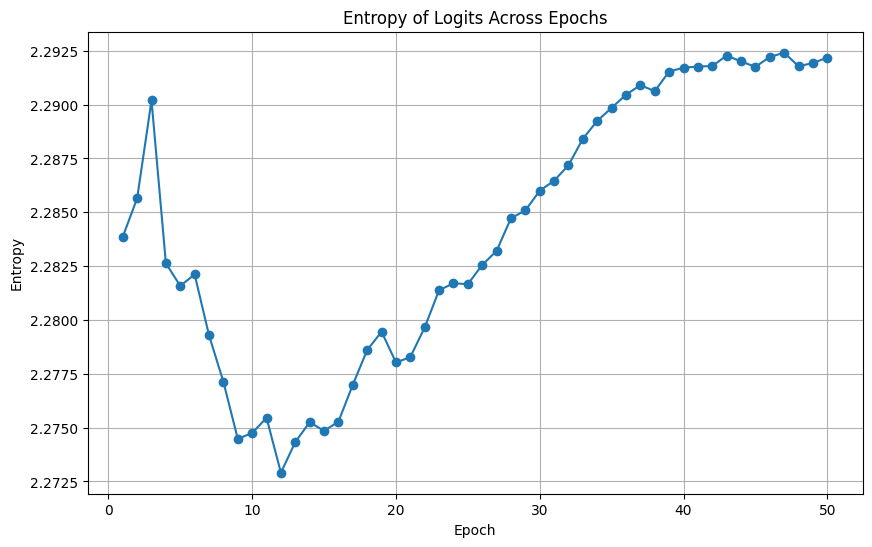

In [28]:
# Plot entropy and mutual information
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), entropy_values, marker='o', label="Entropy")
plt.plot(range(1, num_epochs + 1), mi_values, marker='x', label="Mutual Information")
plt.title("Entropy and Mutual Information Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [11]:
# Track entropy
entropy_values = []

# Training Loop
for epoch in range(1, num_epochs + 1):
    total_loss = 0
    entropies = []

    for (x_labeled, y_labeled), (x_unlabeled, _) in zip(labeled_loader, unlabeled_loader):
        x_labeled, y_labeled = x_labeled.to(device), y_labeled.to(device)
        x_unlabeled = x_unlabeled.to(device)

        optimizer.zero_grad()
        # Forward pass for labeled data
        y_onehot = F.one_hot(y_labeled, model.num_classes).float().to(device)
        #recon_labeled, mean_l, log_var_l, logits_l = model(x_labeled, y_onehot=y_onehot)
        #loss_labeled = m2_loss_labeled(recon_labeled, x_labeled, mean_l, log_var_l, logits_l, y_labeled)

        # Forward pass for unlabeled data
        recon_unlabeled, mean_u, log_var_u, logits_u = model(x_unlabeled)
        loss_unlabeled = optimized_ELBO_unlabeled(recon_unlabeled, x_unlabeled, mean_u, log_var_u, logits_u)

        # Combine losses
        loss =  loss_unlabeled
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        

        # Calculate entropy
        _, entropy = mutual_info_ent(logits_u, x_unlabeled, device)
        entropies.append(entropy.item())


    entropy_values.append(sum(entropies) / len(entropies))
    print(f"Epoch {epoch}: Loss: {total_loss:.4f}, Avg Entropy: {entropy_values[-1]:.4f}")

Epoch 1: Loss: 3474.0882, Avg Entropy: 0.6116
Epoch 2: Loss: 3354.9579, Avg Entropy: 0.2209
Epoch 3: Loss: 3344.5190, Avg Entropy: 0.2157
Epoch 4: Loss: 3371.1396, Avg Entropy: 0.2164
Epoch 5: Loss: 3319.2975, Avg Entropy: 0.2140
Epoch 6: Loss: 3320.5373, Avg Entropy: 0.2136
Epoch 7: Loss: 3347.8651, Avg Entropy: 0.2153
Epoch 8: Loss: 3316.7132, Avg Entropy: 0.2131
Epoch 9: Loss: 3322.0462, Avg Entropy: 0.2138
Epoch 10: Loss: 3318.8415, Avg Entropy: 0.2145
Epoch 11: Loss: 3300.3320, Avg Entropy: 0.2132
Epoch 12: Loss: 3293.8060, Avg Entropy: 0.2130
Epoch 13: Loss: 3287.5953, Avg Entropy: 0.2141
Epoch 14: Loss: 3289.8119, Avg Entropy: 0.2131
Epoch 15: Loss: 3259.1125, Avg Entropy: 0.2121
Epoch 16: Loss: 3280.0645, Avg Entropy: 0.2139
Epoch 17: Loss: 3290.9001, Avg Entropy: 0.2122
Epoch 18: Loss: 3262.9755, Avg Entropy: 0.2117
Epoch 19: Loss: 3277.0557, Avg Entropy: 0.2123
Epoch 20: Loss: 3251.9574, Avg Entropy: 0.2137
Epoch 21: Loss: 3255.3535, Avg Entropy: 0.2128
Epoch 22: Loss: 3263.1

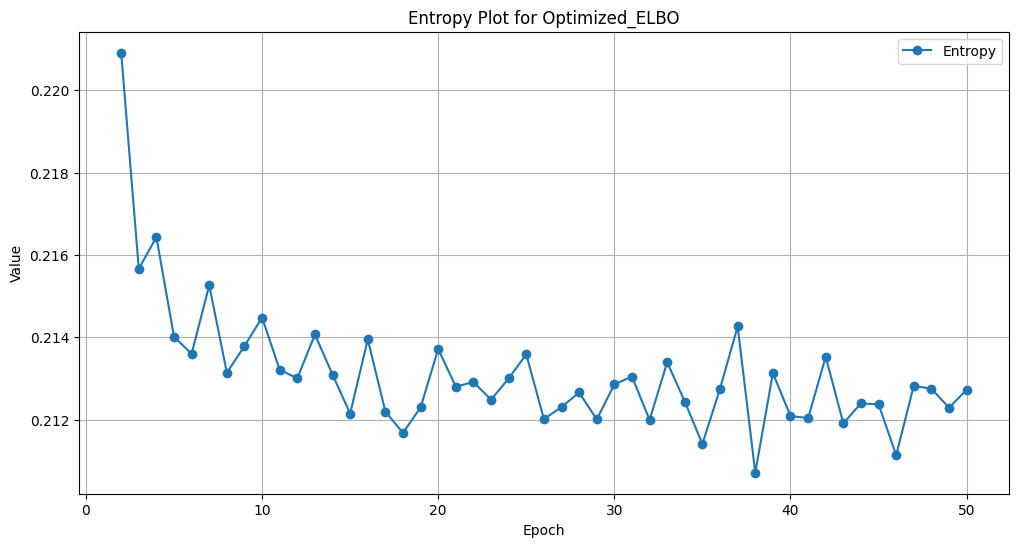

In [16]:
# Plot entropy from the 2nd epoch onwards
plt.figure(figsize=(12, 6))
plt.plot(range(2, num_epochs + 1), entropy_values[1:], marker='o', label="Entropy")

plt.title("Entropy Plot for Optimized_ELBO")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()
